In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight
from wordcloud import WordCloud

In [2]:
# Load dataset with error handling
try:
    data = pd.read_csv('spam.csv', encoding='latin-1')
    data = data[['v1', 'v2']]  # Selecting relevant columns
    data.columns = ['label', 'message']  # Renaming columns
except FileNotFoundError:
    print("Error: The file was not found. Please check the file path.")
    exit()
except Exception as e:
    print(f"An error occurred: {e}")
    exit()

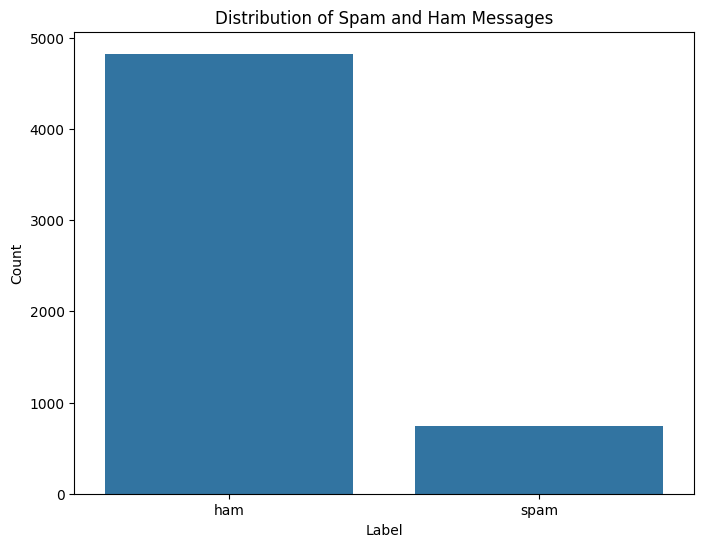

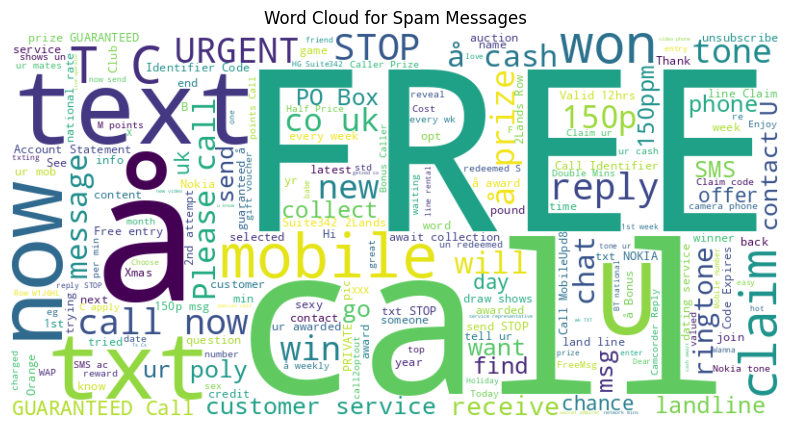

In [3]:
# EDA
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=data)
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

spam_messages = ' '.join(data[data['label'] == 'spam']['message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_messages)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

In [4]:
# Preprocess data
data['message'] = data['message'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x.lower()))

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['label'], test_size=0.2, random_state=42)

In [6]:
# Feature extraction
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [7]:
# Convert labels to numerical format
y_train_numeric = np.where(y_train == 'spam', 1, 0)  # Convert 'spam' to 1 and 'ham' to 0
y_test_numeric = np.where(y_test == 'spam', 1, 0)  # Convert 'spam' to 1 and 'ham' to 0 for evaluation

In [8]:
# Handling imbalanced classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train_numeric)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [9]:
# Define the parameter grid including class_weight
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'class_weight': [class_weights_dict, None]  # Use the computed class weights and also try without
}

In [11]:
# Initialize GridSearchCV without the class_weight in the model constructor
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5, scoring='accuracy')

In [12]:
# Fit the model with GridSearchCV
grid_search.fit(X_train_tfidf, y_train_numeric)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.1, 1, 10],
                         'class_weight': [{0: 0.5773316062176166,
                                           1: 3.7328308207705194},
                                          None],
                         'penalty': ['l2']},
             scoring='accuracy')

In [13]:
# Get the best model
best_model = grid_search.best_estimator_
print("Best parameters for Logistic Regression:", grid_search.best_params_)

Best parameters for Logistic Regression: {'C': 10, 'class_weight': {0: 0.5773316062176166, 1: 3.7328308207705194}, 'penalty': 'l2'}


In [14]:
# Evaluation
y_pred = best_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test_numeric, y_pred))  # Use y_test_numeric for evaluation
print(classification_report(y_test_numeric, y_pred, target_names=['ham', 'spam'], zero_division=0))

Accuracy: 0.9757847533632287
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       965
        spam       0.92      0.89      0.91       150

    accuracy                           0.98      1115
   macro avg       0.95      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

